# Testing the method on synthetic data

[Back to the index](00_index.ipynb)

Here we make sure the Bayesian method developed in the project works. For that, we applied it to synthetic data for which we know the true relations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

import mcmc as xm
import gensynth as gs

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Configuring synthetic samples

Let us create samples with specified $\Delta P(A, B)$ for the binary variables $A$ and $B$. For that we will recall that:

$$\Delta P(A, B) \equiv P(A=1|B=1) - P(A=1).$$

For generating the synthetic $(A, B)$ samples, we need to recall that, from the law of total probability:

$$P(A=1|B=0) = \frac{P(A=1) - P(A=1|B=1)P(B=1)}{P(B=0)}$$.

When generating data with a given $\Delta P(A,B)$, $P(A)$ and $P(B)$ will be treated as nuisance parameters. 

In [2]:
# \Delta P(A,B), P(A), P(B), N_samples:
settings = [(0.0, 0.7, 0.2, 50), (-0.1, 0.7, 0.2, 50), (0.1, 0.7, 0.2, 50), (0.6, 0.4, 0.2, 50), (-0.6, 0.7, 0.2, 50),
            (0.0, 0.7, 0.2, 1000), (-0.1, 0.7, 0.2, 1000), (0.1, 0.7, 0.2, 1000), (0.6, 0.4, 0.2, 1000), (-0.6, 0.7, 0.2, 1000)]

## Basic tests

In [3]:
# Test: result must be the same as Pa:
Pa = 0.6
Pb = 0.2
b0, b1 = gs.compute_cond_probs(-0.5, Pa, Pb)
b0 * (1 - Pb) + b1 * Pb

0.6

In [4]:
# Check if generated P(A) and P(B) are ok:
s = settings[3]
a_arr, b_arr = gs.gen_sample(*s)
print(s[1], a_arr.mean())
print(s[2], b_arr.mean())

0.4 0.42
0.2 0.22


In [5]:
{'N{}{}'.format(i, j): ((a_arr == i) & (b_arr == j)).sum() for i in [0,1] for j in [0,1]}

{'N00': 29, 'N01': 0, 'N10': 10, 'N11': 11}

In [ ]:
# Run chains for all cases:
chains = []
for s in settings:
    # Generate sample:
    a_arr, b_arr = gs.gen_sample(*s)
    df = pd.DataFrame({'A': a_arr, 'B': b_arr})
    # Create chain:
    chain_df = xm.mcmc_sample_multinomial_pars(df, 'A', 'B')
    # Store chain:
    chains.append(chain_df)

In [ ]:
# Save chains:
if False:
    for i, cdf in enumerate(chains):
        cdf.to_csv('../data/sim_chains/chain_{:02d}.csv'.format(i), index=False)

## Loading chains

In [6]:
# Load previously saved chains:
if True:
    chains = [pd.read_csv('../data/sim_chains/chain_{:02d}.csv'.format(i)) for i in range(10)]

## Plot the posteriors

In [7]:
# Select a subset of the chains:
selection = [0, 1, 2, 3, 4, 5, 6, 8]
sel_settings = [settings[i] for i in selection]
sel_chains = [chains[i] for i in selection]

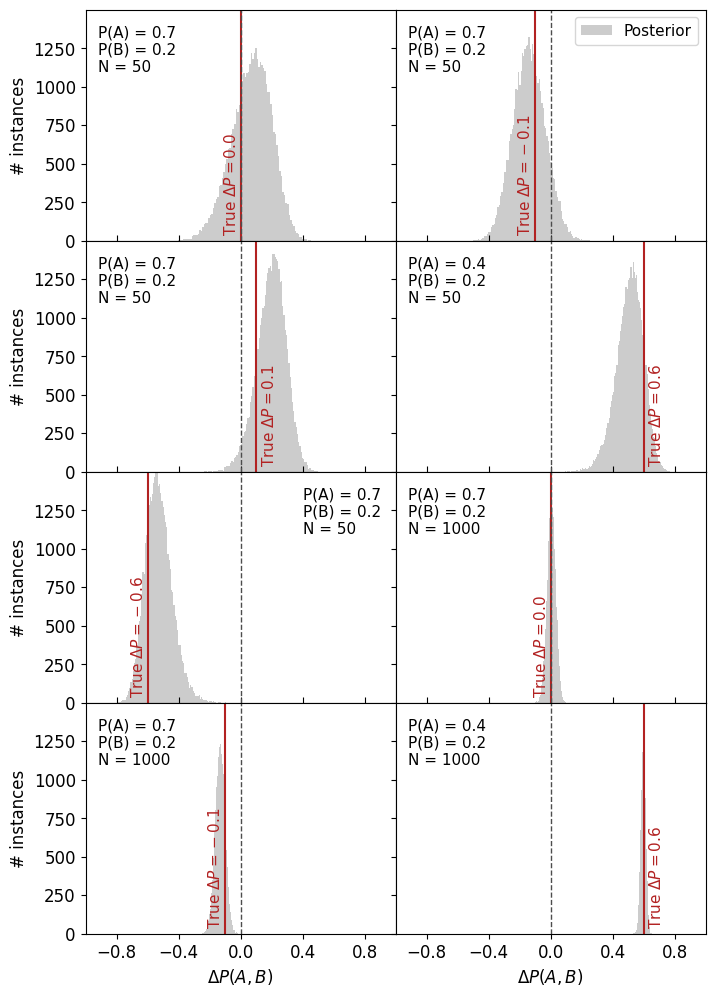

In [8]:
fsize = 12
pl.figure(figsize=(8,12))
for i in range(len(sel_settings)):
    ax = pl.subplot(4, 2, i + 1)
    ss = sel_settings[i]
    # Plot:
    sel_chains[i]['sPa'].hist(bins=100, color='0.8', grid=False, label='Posterior')
    pl.axvline(ss[0], color='firebrick')
    pl.axvline(0, color='0.3', linewidth=1, linestyle='--')
    pl.xlim([-1,1])
    pl.ylim([0,1500])
    # Text:
    info = 'P(A) = {}\nP(B) = {}\nN = {}'.format(ss[1], ss[2], ss[3])
    pl.text(-0.92 if i != 4 else 0.4, 1400, info, va='top', fontsize=11)
    
    pl.text(ss[0] + (0.03 if ss[0] > 0 else -0.01), 30, 
            'True $\Delta P = {}$'.format(ss[0]), ha='left' if ss[0] > 0 else 'right', 
            va='bottom', rotation='vertical', color='firebrick', fontsize=11)
    # Format:
    ax.yaxis.set_tick_params(labelsize=fsize)
    ax.xaxis.set_tick_params(labelsize=fsize)
    pl.xticks([-0.8, -0.4, 0.0, 0.4, 0.8])
    pl.yticks(range(0, 1500, 250))
    if i % 2 == 0:
        pl.ylabel('# instances', fontsize=fsize)
    else:
        ax.yaxis.set_tick_params(labelleft=False)
    if i > 5:
        pl.xlabel('$\Delta P(A, B)$', fontsize=fsize)
    else:
        ax.xaxis.set_tick_params(direction='inout', length=8)
        ax.xaxis.set_tick_params(labelleft=False)
    
    
    # Legend:
    if i == 1:
        pl.legend(fontsize=11, loc='upper right')
pl.subplots_adjust(hspace=0, wspace=0)
#pl.savefig('plots/synthetic_posteriors.eps', bbox_inches='tight')

In [14]:
sel_chains[1]['sPa'].mean()

-0.13765009020724026

In [13]:
(sel_chains[1]['sPa'] > 0).mean()

0.097225

In [9]:
sel_chains[0]['sPa'].mean()

0.07125493233801618

## Other tests

### If $\Delta P (A, B)$ is significant, so is $\Delta P (B, A)$

In [119]:
# \Delta P(A,B) is related to \Delta P(B,A):
for chain_df in chains:
    print(np.isclose(chain_df['sPa'] * chain_df['Pb'] / chain_df['Pa'], chain_df['sPb']).all())

True
True
True
True
True
True
True
True
True
True


<Axes: >

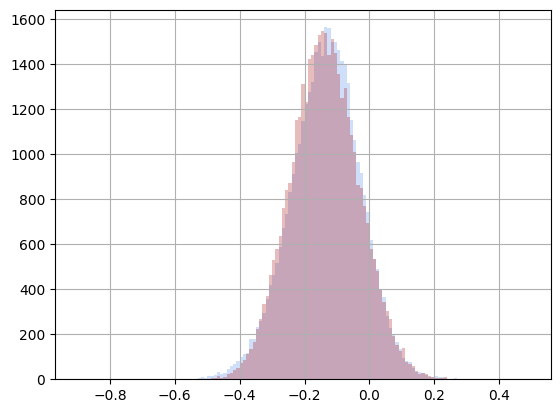

In [153]:
chain_df = chains[1]
edges = np.arange(-0.9, 0.5, 0.01)
#(chain_df['sPb'] * 3.4).hist(bins=100, alpha=0.3, color='cornflowerblue', density=True)
(chain_df['sPb'] * 1.9).hist(bins=edges, alpha=0.3, color='cornflowerblue')
chain_df['sPa'].hist(bins=edges, alpha=0.3, color='firebrick')

In [161]:
for chain_df in chains:
    print((chain_df['sPa'] > 0.0).sum() == (chain_df['sPb'] > 0.0).sum())

True
True
True
True
True
True
True
True
True
True


### Analytical computation of the posterior

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as pl

import xavy.dataframes as xd
import mcmc as xm
import gensynth as gs

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### Generate data

In [2]:
# Generate data:
a_arr, b_arr = gs.gen_sample(0.6, 0.4, 0.2, 50, 48321)
data_df = pd.DataFrame({'A': a_arr, 'B': b_arr})

contingency = {'N{}{}'.format(i, j): ((a_arr == i) & (b_arr == j)).sum() for i in [0,1] for j in [0,1]}
contingency

{'N00': 28, 'N01': 0, 'N10': 9, 'N11': 13}

In [11]:
# Create chain:
chain_df = xm.mcmc_sample_multinomial_pars(data_df, 'A', 'B')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 13 seconds.


#### Analytical model

In [3]:
def my_post_dirichlet(pvec, n):
    """
    Compute the posterior distribution obtained 
    from a multinomial with `n` observations and
    a Dirichlet prior with alpha = 1.

    Paramerers
    ----------
    pvec : array, shape (n_dims, n_points)
        Probabilities for which to compute the posterior.
        Each row (axis=0) is a different prob. dimension,
        and each column (axis=1) is a different point to 
        compute the posterior.
    n : array, shape (n_dims)
        Number of counts of each variable (dimension).

    Returns
    -------
    result : array, shape (n_points)
        Value of the posterior for the provided points.
    """

    assert len(pvec) == len(n)
    
    # Compute the normalization:
    K = len(n)
    N = n.sum()
    numerator   = np.math.factorial(K - 1 + N)
    denominator = np.prod([np.math.factorial(m) for m in n])
    norm = numerator / denominator
    
    # Raise probs. to counts power:
    ppow = np.power(pvec.T, n).T
    # Multiply them:
    pprod = np.prod(ppow, axis=0)

    result = norm * pprod

    return result

In [4]:
# Create table of support points for the PDF:
dx = 0.002
x1 = np.arange(dx, 1, dx)
x2 = np.arange(dx, 1, dx)
x3 = np.arange(dx, 1, dx)
support_df = xd.cross_join_columns(pd.DataFrame({'p00':x1, 'p01':x2, 'p10': x3}))
support_df = support_df.loc[support_df.sum(axis=1) < 1 - dx / 2].reset_index(drop=True)
n_digits = -int(np.floor(np.log10(dx)))
support_df['p11'] = (1 - support_df['p00'] - support_df['p01'] - support_df['p10']).round(n_digits)

In [5]:
# The prior is constant with value 6:
prior_ct = 6
p = sc.stats.dirichlet.pdf(support_df.values.T, [1,1,1,1])
np.isclose(p, prior_ct * np.ones_like(p)).all()

True

In [6]:
# Expected value of the prior according to Wikipedia:
K = 4
wiki_ct = sc.special.gamma(K) / sc.special.gamma(1) ** K
print(wiki_ct)
np.isclose(wiki_ct, prior_ct)

6.0


True

In [7]:
# Compute the PDF:
p0 = 1
n_vec = np.array(list(contingency.values()))
a  = np.array([p0 + n for n in n_vec])
support_df['pdf'] = sc.stats.dirichlet.pdf(support_df.values.T, a)
support_df['my_pdf'] = my_post_dirichlet(support_df.drop('pdf', axis=1).values.T, n_vec)

In [8]:
# Check that my formula is Correct: 
np.isclose(support_df['pdf'], support_df['my_pdf']).all()

True

In [9]:
# Check the normalization:
support_df['pdf'].sum() * dx ** 3

0.9479185105283299

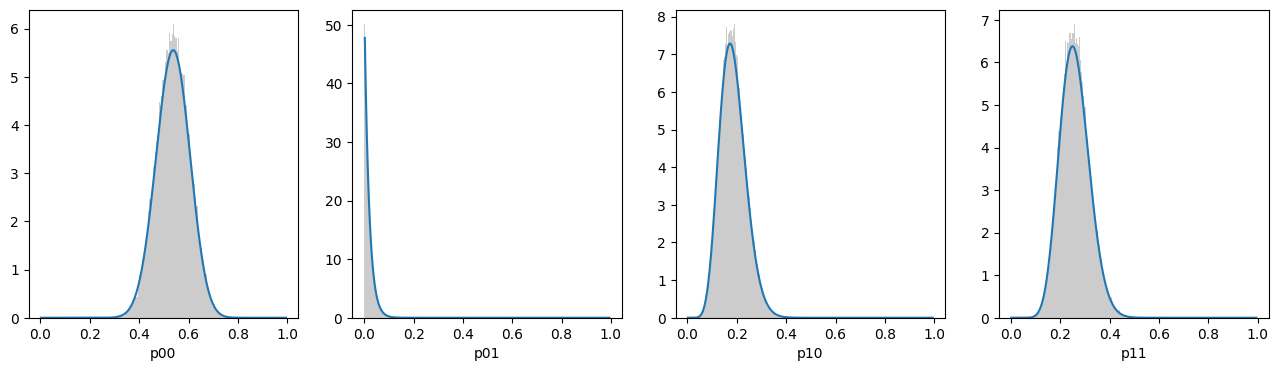

In [12]:
# Compare MCMC chain to analytical PDF:
pl.figure(figsize=(16,4))
for i, pij in enumerate(['p00', 'p01', 'p10', 'p11']):
    pl.subplot(1,4,i+1)
    marginal = support_df.groupby(pij)['pdf'].sum().sort_index() * dx ** 2
    chain_df[pij].hist(bins=100, density=True, color='0.8')
    marginal.plot()

In [13]:
# Add variable Delta P(A,B):
support_df['dpa'] = (support_df['p11'] / (support_df['p11'] + support_df['p01']) - support_df['p10'] - support_df['p11']).round(n_digits)

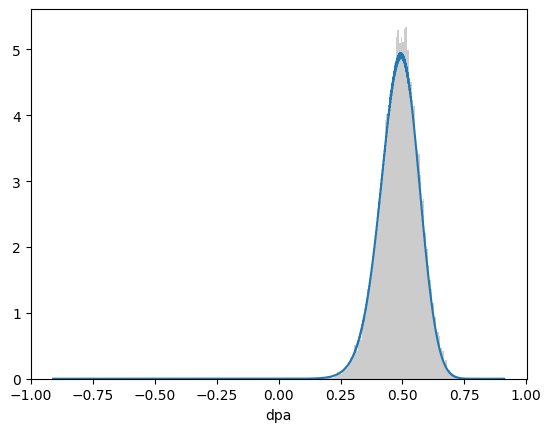

In [14]:
# Compare chains with PDF for Delta P:
ddp = support_df.groupby('dpa')['pdf'].sum().sort_index() * dx ** 2 * 2
chain_df['sPa'].hist(bins=100, density=True, color='0.8')
ddp.plot();

#### Toy example: 1D

In [9]:
x = np.arange(0.01, 1.0, 0.01)
basic_df = pd.DataFrame({'x':x, 'y':1 - x})
basic_df['pdf'] = sc.stats.dirichlet.pdf(basic_df.values.T, np.array([5,3]))
basic_df.head()

,x,y,pdf
0,0.01,0.99,0.000001
1,0.02,0.98,0.000016
2,0.03,0.97,0.000080
3,0.04,0.96,0.000248
4,0.05,0.95,0.000592


In [5]:
# Normalization:
basic_df['pdf'].sum() * 0.01

0.9999999650025007

#### Toy example: 2D

In [10]:
dx = 0.01
x1 = np.arange(dx, 1, dx)
x2 = np.arange(dx, 1, dx)
x3 = np.arange(dx, 1, dx)
two_df = xd.cross_join_columns(pd.DataFrame({'x1':x1, 'x2':x2, 'x3': x3}))
two_df = two_df.loc[np.isclose(two_df.sum(axis=1), 1)].reset_index(drop=True)

two_df['pdf'] = sc.stats.dirichlet.pdf(two_df.values.T, np.array([9,5,2]))

In [11]:
# Normalization:
two_df['pdf'].sum() * 0.01 ** 2

0.9982513649990452

### Comparing (Multinomial + Prior) with updated Dirichlet 

In [11]:
import pymc as pm
import numpy as np
import pandas as pd
import time

import sys
sys.path.append("../")
import brass as br

#### Set input

In [28]:
# Set parameters of the test:
prior_alpha = np.array([1,1,1,1])
pair_counts = np.array([500, 300, 200, 400])
prior_name  = 'pair_probs'
par_name    = prior_name

#### Create models

In [29]:
# Create fast model:
with pm.Model() as model1:
    
    # Prior (distribuição multivariada uniforme sujeita ao vínculo $\sum p_i = 1$):
    pair_probs = pm.Dirichlet(prior_name, prior_alpha + pair_counts)

In [30]:
# Create slow model:
with pm.Model() as model2:
    
    # Prior (distribuição multivariada uniforme sujeita ao vínculo $\sum p_i = 1$):
    pair_probs = pm.Dirichlet(prior_name, prior_alpha)
    
    # Cria Likelihood:
    total_counts = pair_counts.sum()
    obs_counts = pair_counts.reshape(1, len(pair_counts))
    gen_counts = pm.Multinomial('gen_counts', n=total_counts, p=pair_probs, shape=obs_counts.shape, observed=obs_counts)

#### Run models

In [31]:
# Sample fast model:
start_time = time.time()
with model1:
    idata1 = pm.sample(draws=10000)
print("--- {:.2f} seconds ---".format(time.time() - start_time))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 9 seconds.


--- 22.48 seconds ---


In [32]:
# Sample slow model:
start_time = time.time()
with model2:
    idata2 = pm.sample(draws=10000)
print("--- {:.2f} seconds ---".format(time.time() - start_time))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 10 seconds.


--- 27.64 seconds ---


#### Compare results

In [33]:
my = br.AssocEstimator([1,1,1,1])

In [34]:
df1 = my._add_derived_probs(my._idata2df(idata1))
df2 = my._add_derived_probs(my._idata2df(idata2))

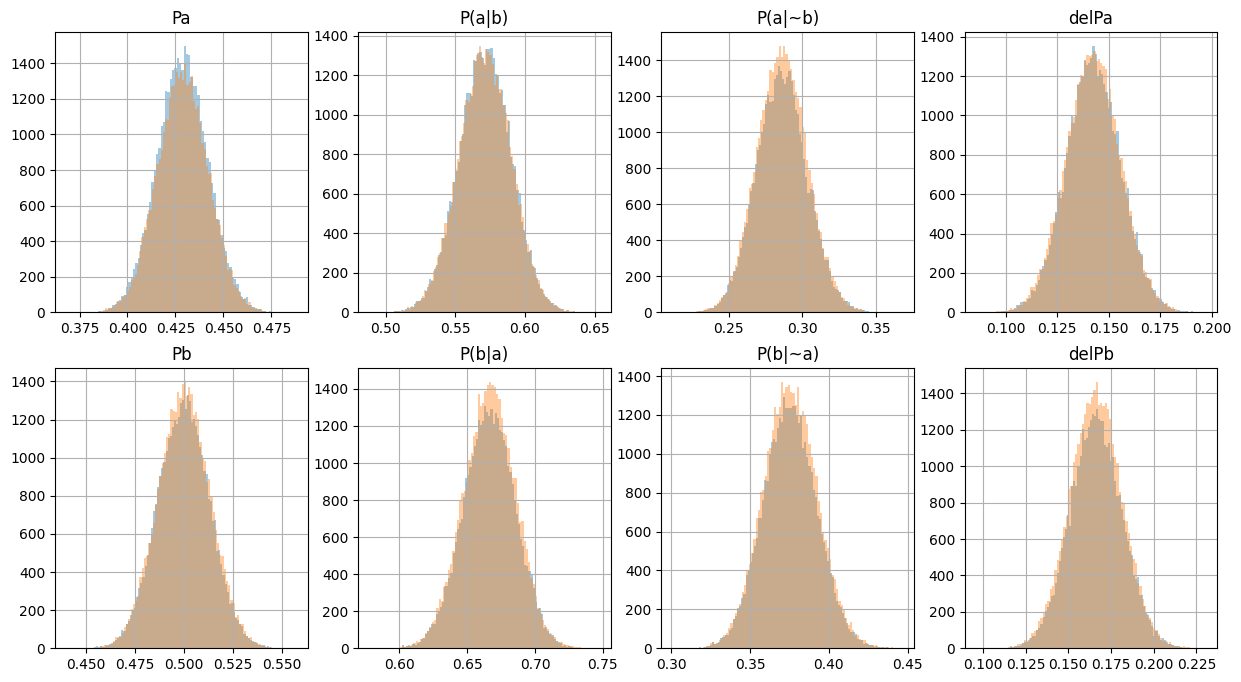

In [36]:
my.plot_chain_probs(df1, bins=100)
my.plot_chain_probs(df2, bins=100, figsize=None)

### Rare events

In [25]:
import pandas as pd
import matplotlib.pyplot as pl

import sys
sys.path.append("../")
import brass as br

#### Generate synthetic data

In [161]:
# Set parameters:
N_samples = 500
deltaP = 0.03
P_rare = 0.1
P_common = 0.8
gen_common = br.VarGenerator(deltaP, P_common, P_common)
gen_rare   = br.VarGenerator(deltaP, P_rare, P_rare)

In [162]:
# Generate samples:
a_common, b_common = gen_common.sample(N_samples, seed=55)
df_common = pd.DataFrame({'A': a_common, 'B': b_common})
a_rare, b_rare = gen_rare.sample(N_samples, seed=52)
df_rare = pd.DataFrame({'A': a_rare, 'B': b_rare})

In [163]:
est_common._count_onehot_pairs(df_common)

array([ 32,  71,  55, 342])

In [164]:
est_rare._count_onehot_pairs(df_rare)

array([396,  44,  53,   7])

#### Measuring associations

In [165]:
est_common = br.AssocEstimator(onehot_trials=df_common)
est_rare   = br.AssocEstimator(onehot_trials=df_rare)

In [166]:
n_draws = 10000
chain_common_df = est_common.sample_model(n_draws)
chain_rare_df   = est_rare.sample_model(n_draws)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 7 seconds.


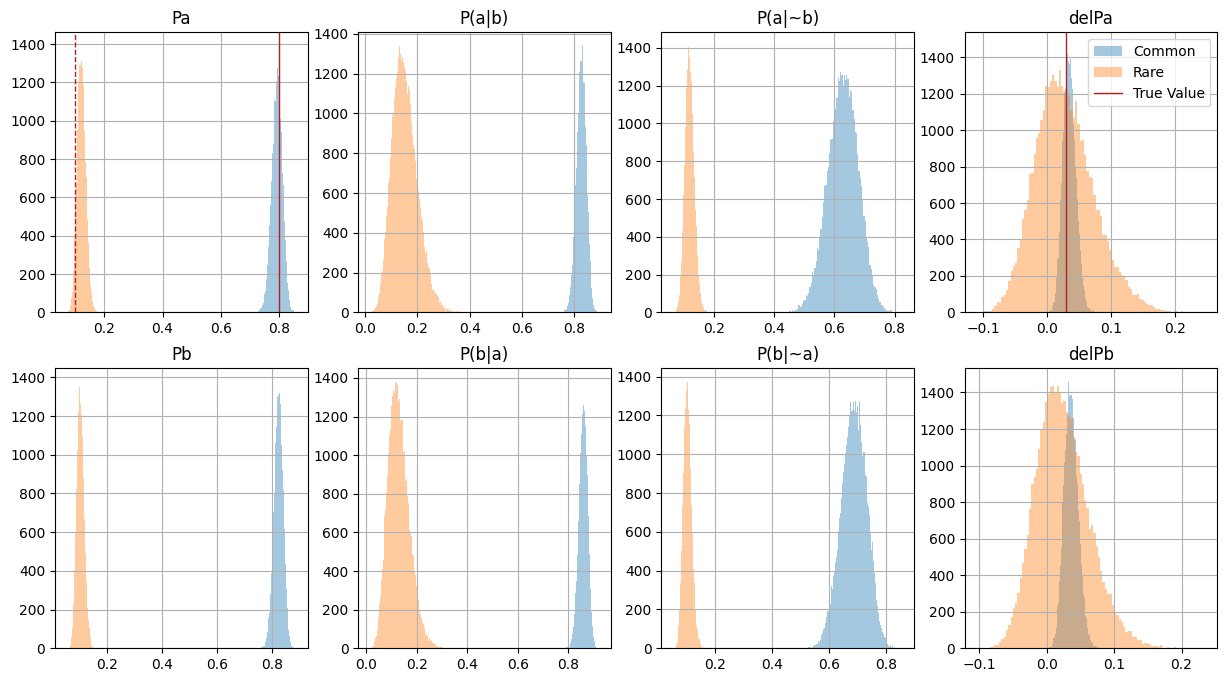

In [167]:
n_bins = 100
# Dist:
est_common.plot_chain_probs(chain_common_df, bins=n_bins, label='Common')
est_rare.plot_chain_probs(chain_rare_df, bins=n_bins, label='Rare', figsize=None)
# True values:
pl.subplot(2,4,1)
pl.axvline(P_common, color='firebrick', linewidth=1)
pl.axvline(P_rare, color='firebrick', linewidth=1, linestyle='--')
pl.subplot(2,4,4)
pl.axvline(deltaP, color='firebrick', linewidth=1, label='True Value')

pl.legend()
pl.show()